# Handling outliers and dealing with class imbalance

In [ ]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import pickle

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans
from nltk.tokenize import word_tokenize, sent_tokenize
from imblearn.under_sampling import TomekLinks
from collections import defaultdict
from time import time

In [ ]:
pet_dataset = pd.read_csv('prepros2_dataset.csv')


<ipython-input-2-1a319989bc33>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  pet_dataset = pd.read_csv('/content/drive/MyDrive/Thesis/prepros2_dataset.csv')


## Handling outliers

In [ ]:
#tokenizing the descriptions
pet_dataset['description'] = pet_dataset['description'].astype(str)
pet_dataset['description_words'] = pet_dataset['description'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# counting the words

pet_dataset['word_count'] = pet_dataset['description_words'].apply(len)

In [ ]:
pet_dataset

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
0,0,Cat,Baby,Male,Black,Small,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,3,Adopted,"[Nibble, is, a, 3+, month, old, ball, of, cute...",76
1,1,Cat,Baby,Male,Black,Medium,I just found it alone yesterday near my apartm...,6296e909a,1,Adopted,"[I, just, found, it, alone, yesterday, near, m...",25
2,2,Dog,Baby,Male,Brown_Chocolate,Medium,Their pregnant mother was dumped by her irresp...,3422e4906,2,Adopted,"[Their, pregnant, mother, was, dumped, by, her...",78
3,3,Dog,Baby,Female,Black,Medium,"Good guard dog, very alert, active, obedience ...",5842f1ff5,3,Adopted,"[Good, guard, dog, ,, very, alert, ,, active, ...",32
4,4,Dog,Baby,Male,Black,Medium,This handsome yet cute boy is up for adoption....,850a43f90,1,Adopted,"[This, handsome, yet, cute, boy, is, up, for, ...",88
...,...,...,...,...,...,...,...,...,...,...,...,...
681337,690992,Dog,Senior,Female,Other,Small,Chiquita is a 12 year old chihuahua that just ...,42301573,1,Unadopted,"[Chiquita, is, a, 12, year, old, chihuahua, th...",2148
681338,690993,Dog,Adult,Male,White_Cream,Extra Large,5/5/18: JoJo sure would like a family of his o...,32928096,3,Unadopted,"[5/5/18, :, JoJo, sure, would, like, a, family...",2088
681339,690994,Dog,Adult,Male,Unknown,Medium,You can fill out an adoption application onlin...,40855857,3,Unadopted,"[You, can, fill, out, an, adoption, applicatio...",2181
681340,690995,Cat,Adult,Male,Black_White,Medium,"Found Cat who needs a home ""Kitty"" ? Found Cat...",28488675,1,Unadopted,"[Found, Cat, who, needs, a, home, ``, Kitty, '...",2513


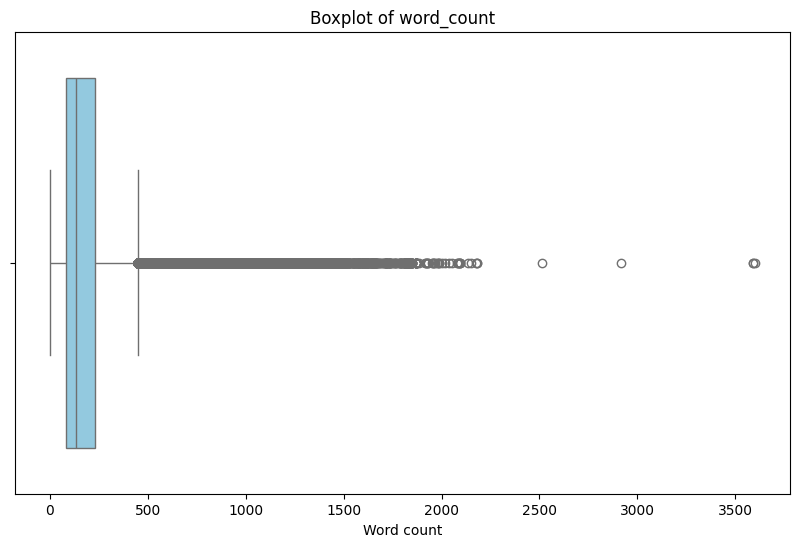

In [ ]:

# visualizing the distribution of the word_count column with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=pet_dataset['word_count'], color = 'skyblue')
plt.title('Boxplot of word_count')
plt.xlabel('Word count')
plt.show()



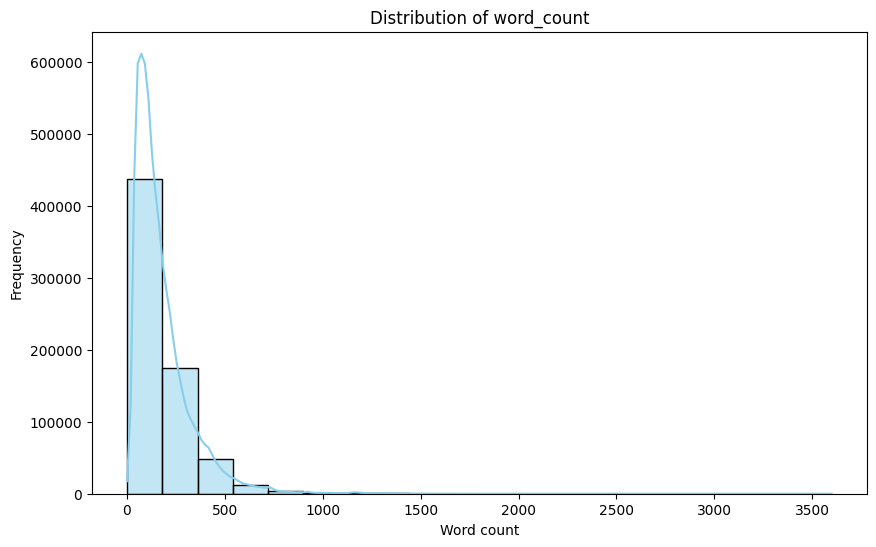

In [ ]:
# creating a histogram for word_count to see the skewness before removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(pet_dataset['word_count'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of word_count')
plt.xlabel('Word count')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# calculate the IQR for the 'word_count' column and defining the upper bound
Q1 = pet_dataset['word_count'].quantile(0.25)
Q3 = pet_dataset['word_count'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

# removing all outliers that are higher than the upper bound
pet_dataset2 = pet_dataset[pet_dataset['word_count'] <= upper_bound]

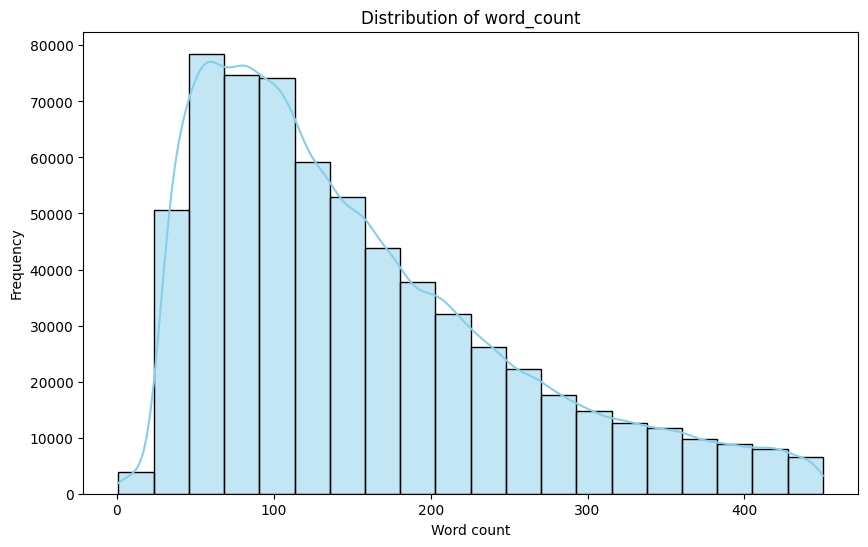

In [ ]:
# creating a histogram for word_count to see the skewness after removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(pet_dataset2['word_count'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of word_count')
plt.xlabel('Word count')
plt.ylabel('Frequency')

plt.show()

## Dealing with class imbalance

In [ ]:
# visualizing the class imbalance

adoption_count = pet_dataset2['adopted'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=adoption_count.index, y=adoption_count.values, palette='pastel')

plt.title('Adoptability distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
unadopted_pets = pet_dataset2[pet_dataset2['adopted'] == 'Unadopted']
adopted_pets = pet_dataset2[pet_dataset2['adopted'] == 'Adopted']

In [ ]:
adopted_pets['description'].fillna('', inplace=True)

<ipython-input-73-a63cad625965>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_pets['description'].fillna('', inplace=True)


In [ ]:
unadopted_pets

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
9,9,Cat,Young,Female,Black,Medium,"Very manja and gentle stray cat found, we woul...",7a0942d61,1,Unadopted,"['Very', 'manja', 'and', 'gentle', 'stray', 'c...",388
15,15,Dog,Adult,Male,Black,Medium,We moved out of our apartment to a landed home...,1fd342e17,3,Unadopted,"['We', 'moved', 'out', 'of', 'our', 'apartment...",584
17,17,Dog,Young,Female,Brown_Chocolate,Medium,shes active... she can obey wht command that u...,f9d07d5fa,3,Unadopted,"['shes', 'active', '...', 'she', 'can', 'obey'...",668
19,19,Cat,Baby,Mixed,Black,Small,"Birth Date: Oct 30th Kitty 1, Melly -Female Sa...",b10e7605a,1,Unadopted,"['Birth', 'Date', ':', 'Oct', '30th', 'Kitty',...",893
21,21,Dog,Baby,Female,Gray,Medium,"Three puppies abandoned on the street, picked ...",234a5a54c,1,Unadopted,"['Three', 'puppies', 'abandoned', 'on', 'the',...",153
...,...,...,...,...,...,...,...,...,...,...,...,...
678931,685968,Dog,Adult,Male,Unknown,Medium,"Woof! It's me Moose, a 2 year old Border Colli...",42312550,3,Unadopted,"['Woof', '!', 'It', ""'s"", 'me', 'Moose', ',', ...",3610
678941,685978,Dog,Adult,Male,Unknown,Medium,"Hi there! My name is Zagnut, but my foster mom...",41380802,5,Unadopted,"['Hi', 'there', '!', 'My', 'name', 'is', 'Zagn...",3628
678967,686004,Cat,Young,Female,Unknown,Medium,Please contact Tia (tkocianic@yahoo.com) for m...,39027997,3,Unadopted,"['Please', 'contact', 'Tia', '(', 'tkocianic',...",3621
679049,686088,Dog,Adult,Female,Unknown,Medium,Hello world! My name is Tassels and I am excit...,42083623,3,Unadopted,"['Hello', 'world', '!', 'My', 'name', 'is', 'T...",3596


In [ ]:
adopted_pets

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
0,0,Cat,Baby,Male,Black,Small,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,3,Adopted,"['Nibble', 'is', 'a', '3+', 'month', 'old', 'b...",595
1,1,Cat,Baby,Male,Black,Medium,I just found it alone yesterday near my apartm...,6296e909a,1,Adopted,"['I', 'just', 'found', 'it', 'alone', 'yesterd...",196
2,2,Dog,Baby,Male,Brown_Chocolate,Medium,Their pregnant mother was dumped by her irresp...,3422e4906,2,Adopted,"['Their', 'pregnant', 'mother', 'was', 'dumped...",637
3,3,Dog,Baby,Female,Black,Medium,"Good guard dog, very alert, active, obedience ...",5842f1ff5,3,Adopted,"['Good', 'guard', 'dog', ',', 'very', 'alert',...",250
4,4,Dog,Baby,Male,Black,Medium,This handsome yet cute boy is up for adoption....,850a43f90,1,Adopted,"['This', 'handsome', 'yet', 'cute', 'boy', 'is...",662
...,...,...,...,...,...,...,...,...,...,...,...,...
549749,553495,Dog,Senior,Male,White_Cream,Medium,BOGART aka Boogie bear is a 9 year old male Be...,41122473,3,Adopted,"['BOGART', 'aka', 'Boogie', 'bear', 'is', 'a',...",3621
550216,553966,Dog,Young,Male,Other,Small,Hello-My name is Smoky. I am a tiny 3 year o...,43327497,5,Adopted,"['Hello-My', 'name', 'is', 'Smoky', '.', 'I', ...",3552
550251,554001,Dog,Young,Female,Other,Medium,"Just like the Nella , Princess Knight from the...",41416665,6,Adopted,"['Just', 'like', 'the', 'Nella', ',', 'Princes...",3628
550850,554603,Dog,Adult,Female,Unknown,Medium,Hi! My name is Brandy. I love to explore outsi...,40991481,5,Adopted,"['Hi', '!', 'My', 'name', 'is', 'Brandy', '.',...",3632


### TF-IDF

In [ ]:
# code retrieved from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(adopted_pets['description'])

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 83.119 s
n_samples: 535155, n_features: 46036


### Latent Semantic Analysis

In [ ]:
# code retrieved from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

lsa = make_pipeline(TruncatedSVD(n_components=100, random_state=555), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

np.save("X_lsa_allpet.npy", X_lsa)

LSA done in 100.282 s
Explained variance of the SVD step: 15.9%


### Clustering and finding the representative instances

In [ ]:
# code retrieved from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=111000,
    n_init=1,
    batch_size=10000,
    verbose = 1
)

labels = minibatch_kmeans.fit_predict(X_lsa)



Init 1/1 with method k-means++
Inertia for init 1/1: 65792.27549137367
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 1/5351: mean batch inertia: 0.19543010212698864
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 2/5351: mean batch inertia: 0.2039307724503385, ewa inertia: 0.2039307724503385
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 3/5351: mean batch inertia: 0.21204832731040504, ewa inertia: 0.20423414398537004
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 4/5351: mean batch inertia: 0.20732687007099065, ewa inertia: 0.2043497262113236
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 5/5351: mean batch inertia: 0.20749126501943682, ewa inertia: 0.2044671326800211
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 6/5351: mean batch inertia: 0.20344071085162097, ewa inertia: 0.20442877295581355
[MiniBatchKMeans] Reassigning 5000 cluster centers.
Minibatch step 7/5351

In [ ]:
len(labels)

535155

In [ ]:
with open("pet_minibatch_kmeans_model.pkl", "wb") as f:
    pickle.dump(minibatch_kmeans, f)

np.savetxt("pet_labels.csv", labels, delimiter=",")

In [ ]:
# code retrieved from https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

representatives_idx = []
for i in range(minibatch_kmeans.n_clusters):
    cluster_center = minibatch_kmeans.cluster_centers_[i]
    distances = np.linalg.norm(X_lsa - cluster_center, axis=1) # euclidean distance
    representatives_idx.append(np.argmin(distances)) # finding the instanve with the smallest distance to the cluster centre

    if (i + 1) % 100 == 0:
        print(f"Processed {i+1}/{minibatch_kmeans.n_clusters} clusters") # printing the progress

representatives = adopted_pets.iloc[representatives_idx]

representatives.to_csv('representatives.csv', index=False)



Processed 100/111000 clusters
Processed 200/111000 clusters
Processed 300/111000 clusters
Processed 400/111000 clusters
Processed 500/111000 clusters
Processed 600/111000 clusters
Processed 700/111000 clusters
Processed 800/111000 clusters
Processed 900/111000 clusters
Processed 1000/111000 clusters
Processed 1100/111000 clusters
Processed 1200/111000 clusters
Processed 1300/111000 clusters
Processed 1400/111000 clusters
Processed 1500/111000 clusters
Processed 1600/111000 clusters
Processed 1700/111000 clusters
Processed 1800/111000 clusters
Processed 1900/111000 clusters
Processed 2000/111000 clusters
Processed 2100/111000 clusters
Processed 2200/111000 clusters
Processed 2300/111000 clusters
Processed 2400/111000 clusters
Processed 2500/111000 clusters
Processed 2600/111000 clusters
Processed 2700/111000 clusters
Processed 2800/111000 clusters
Processed 2900/111000 clusters
Processed 3000/111000 clusters
Processed 3100/111000 clusters
Processed 3200/111000 clusters
Processed 3300/11

IndexError: positional indexers are out-of-bounds

In [ ]:
len(representatives_idx)

111000

In [ ]:
representatives

,Unnamed: 0,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
159047,160700,Cat,Adult,Male,Brown_Chocolate,Small,For further information please visit our websi...,41085682,1,Adopted,"['For', 'further', 'information', 'please', 'v...",643
448425,451846,Cat,Young,Male,Unknown,Medium,Bart is a sweet and joyful boy who loves to be...,42779556,2,Adopted,"['Bart', 'is', 'a', 'sweet', 'and', 'joyful', ...",1975
444863,448265,Dog,Adult,Female,Other,Medium,Wake up every morning to someone who truly L?V...,40922487,5,Adopted,"['Wake', 'up', 'every', 'morning', 'to', 'some...",1963
397970,401172,Dog,Baby,Female,Other,Large,Nala is a 9 month old female mix. She is guess...,41787973,6,Adopted,"['Nala', 'is', 'a', '9', 'month', 'old', 'fema...",1558
202576,204571,Cat,Baby,Female,Other,Medium,Yuki is a social butterfly with people and wit...,42801248,1,Adopted,"['Yuki', 'is', 'a', 'social', 'butterfly', 'wi...",809
...,...,...,...,...,...,...,...,...,...,...,...,...
317886,320659,Dog,Young,Male,Unknown,Small,"I'm Hector, a male salt and pepper Miniature S...",42966735,1,Adopted,"['I', ""'m"", 'Hector', ',', 'a', 'male', 'salt'...",1197
144619,146154,Cat,Baby,Female,Other,Medium,a very cute and playful gray tabby female name...,42679536,1,Adopted,"['a', 'very', 'cute', 'and', 'playful', 'gray'...",650
96034,97102,Cat,Baby,Male,Other,Medium,"This little guy was found with Ariel (female, ...",42966031,1,Adopted,"['This', 'little', 'guy', 'was', 'found', 'wit...",475
283922,286483,Cat,Young,Female,Unknown,Medium,My name is Marigold and I am a really special ...,42019984,3,Adopted,"['My', 'name', 'is', 'Marigold', 'and', 'I', '...",977


In [ ]:
balanced_data = pd.concat([representatives, unadopted_pets], axis=0)

In [ ]:
balanced_data['adopted'].value_counts()

adopted
Adopted      111000
Unadopted    110331
Name: count, dtype: int64

In [ ]:
balanced_data = balanced_data.drop('Unnamed: 0', axis=1)

In [ ]:
balanced_data

,pet,age,gender,color,size,description,pid,photos,adopted,description_words,word_count
159047,Cat,Adult,Male,Brown_Chocolate,Small,For further information please visit our websi...,41085682,1,Adopted,"['For', 'further', 'information', 'please', 'v...",643
448425,Cat,Young,Male,Unknown,Medium,Bart is a sweet and joyful boy who loves to be...,42779556,2,Adopted,"['Bart', 'is', 'a', 'sweet', 'and', 'joyful', ...",1975
444863,Dog,Adult,Female,Other,Medium,Wake up every morning to someone who truly L?V...,40922487,5,Adopted,"['Wake', 'up', 'every', 'morning', 'to', 'some...",1963
397970,Dog,Baby,Female,Other,Large,Nala is a 9 month old female mix. She is guess...,41787973,6,Adopted,"['Nala', 'is', 'a', '9', 'month', 'old', 'fema...",1558
202576,Cat,Baby,Female,Other,Medium,Yuki is a social butterfly with people and wit...,42801248,1,Adopted,"['Yuki', 'is', 'a', 'social', 'butterfly', 'wi...",809
...,...,...,...,...,...,...,...,...,...,...,...
678931,Dog,Adult,Male,Unknown,Medium,"Woof! It's me Moose, a 2 year old Border Colli...",42312550,3,Unadopted,"['Woof', '!', 'It', ""'s"", 'me', 'Moose', ',', ...",3610
678941,Dog,Adult,Male,Unknown,Medium,"Hi there! My name is Zagnut, but my foster mom...",41380802,5,Unadopted,"['Hi', 'there', '!', 'My', 'name', 'is', 'Zagn...",3628
678967,Cat,Young,Female,Unknown,Medium,Please contact Tia (tkocianic@yahoo.com) for m...,39027997,3,Unadopted,"['Please', 'contact', 'Tia', '(', 'tkocianic',...",3621
679049,Dog,Adult,Female,Unknown,Medium,Hello world! My name is Tassels and I am excit...,42083623,3,Unadopted,"['Hello', 'world', '!', 'My', 'name', 'is', 'T...",3596


In [ ]:
balanced_data.to_csv('balanced_pet_dataset.csv', index=False)